In [1]:
# Nhập thư viện
import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import matplotlib.cm as cm
from wordcloud import WordCloud

import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from spellchecker import SpellChecker

## Một số thông tin về bộ dữ liệu
- Nguồn gốc của bộ dữ liệu: [Mental Health Corpus](https://www.kaggle.com/datasets/reihanenamdari/mental-health-corpus).

#### Mô tả bộ dữ liệu
- Bộ dữ liệu là dạng Corpus (1 tập hợp các văn bản) trong ngôn ngữ Tiếng Anh.
- Bộ Corpus gồm 2 cột `text` và `label` và 27977 hàng.
- Cột `text` biểu thị cho những bình luận đến từ những người dùng trên nền tảng mạng xã hội.
- Cột `label` gồm các giá trị 0 và 1, trong đó 1 biểu thị cho dấu hiệu của nội dung độc hại hoặc có liên kết với nguy cơ về các vấn đề tâm lý của người viết văn bản đó và 0 được coi là văn bản có thể bỏ qua trong mục đích trên.

***Ghi chú:*** Bộ dữ liệu được chia sẻ trên nền tảng [Kaggle](https://www.kaggle.com/) bởi [Reihaneh Namdari](https://www.kaggle.com/reihanenamdari), một nhà phân tích dữ liệu và nhà tâm lý trị liệu. Do những lo ngại về quyền riêng tư, có rất ít thông tin về bộ dữ liệu ngoài những thông tin được cung cấp tại đây. Điều này đưa ra một vài lưu ý:

- Chúng ta không biết dữ liệu đã được thu thập ở nền tảng cụ thể nào hay bằng cách nào.
- Chúng ta không biết thêm được thông tin gì về cá nhân đã viết ra các bình luận.
- Chúng ta không biết bộ dữ liệu đã được thu thập và tạo ra và khoảng thời gian nào.
- Chúng ta chưa thể chắc bộ dữ liệu này có thực sự 100% là dữ liệu từ đời thật.
- Chúng ta chưa thể chắc rằng bộ dữ liệu đã qua các bước xử lí nào và các bước đó đã được thực hiện trên toàn bộ bộ dữ liệu hay chưa.
- Chúng ta chưa thể chắc nếu dữ liệu đã qua các bước chọn lọc, hay thậm chí là chứa dữ liệu mô phỏng khi chưa qua phân tích.

In [2]:
# Chúng ta đọc dữ liệu của Corpus
corpus = pd.read_csv('data/mental_health.csv')

# In ra một vài điểm dữ liệu đầu tiên
print(corpus.head(20))

# In ra shape của DataFrame
print("\nShape of the DataFrame:", corpus.shape)

# In ra thông tin về DataFrame
print(corpus.info())

                                                 text  label
0   dear american teens question dutch person hear...      0
1   nothing look forward lifei dont many reasons k...      1
2   music recommendations im looking expand playli...      0
3   im done trying feel betterthe reason im still ...      1
4   worried  year old girl subject domestic physic...      1
5   hey rredflag sure right place post this goes  ...      1
6   feel like someone needs hear tonight feeling r...      0
7   deserve liveif died right noone would carei re...      1
8   feels good ive set dateim killing friday nice ...      1
9   live guiltok made stupid random choice  its ge...      1
10  excercise motivated ngl cant wait get shape kn...      0
11  know youd rather laid big booty body hella pos...      0
12                      even time fuck  supposed mean      0
13  usual hollywood stereotyped everyone movie but...      0
14  think it nearly unbelievable film could made d...      0
15                      

In [3]:
# Kiểm tra về 1 số đặc điểm của dữ liệu văn bản
non_alpha_mask = corpus['text'].str.contains('[^a-z ]')
empty_or_whitespace_mask = corpus['text'].str.strip().eq('')

non_alpha_indices = corpus[non_alpha_mask].index.tolist()
empty_or_whitespace_indices = corpus[empty_or_whitespace_mask].index.tolist()

print("Rows with non-alphabetic characters:", len(non_alpha_indices))

print("\nIndices of rows that are empty or only whitespace:")
for idx in empty_or_whitespace_indices:
    print(f"Index {idx}: No symbols, empty or whitespace.")

Rows with non-alphabetic characters: 377

Indices of rows that are empty or only whitespace:
Index 6579: No symbols, empty or whitespace.
Index 13183: No symbols, empty or whitespace.


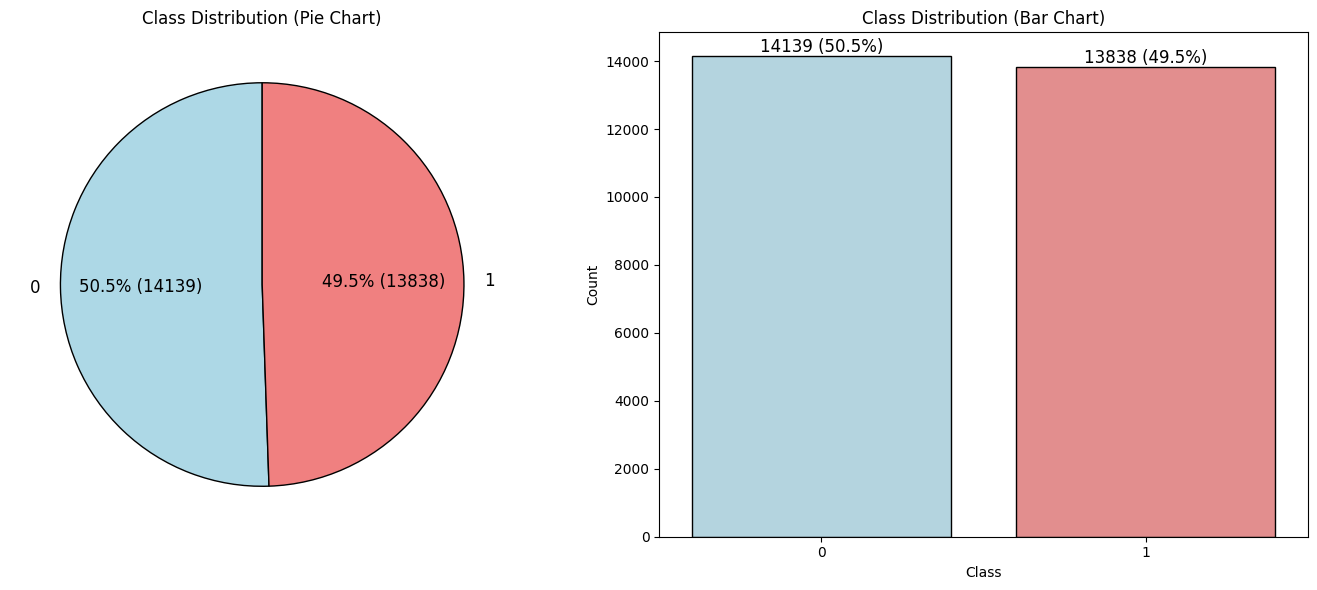

In [4]:
# Quan sát phân bổ của cột 'label'
label_counts = corpus['label'].value_counts()

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
colors = ['lightblue', 'lightcoral']
plt.pie(label_counts, labels=label_counts.index, autopct=lambda p: f'{p:.1f}% ({int(p*sum(label_counts)/100)})',
        colors=colors, startangle=90, wedgeprops={'edgecolor': 'black'}, textprops={'fontsize': 12})
plt.title('Class Distribution (Pie Chart)')

plt.subplot(1, 2, 2)
sns.barplot(x=label_counts.index, y=label_counts, palette=colors, edgecolor='black')
for index, value in enumerate(label_counts):
    plt.text(index, value, f'{value} ({value/sum(label_counts)*100:.1f}%)', ha='center', va='bottom', fontsize=12)
plt.title('Class Distribution (Bar Chart)')
plt.ylabel('Count')
plt.xlabel('Class')

# plt.savefig('plots_and_graphs/org_class_distribution.png', format='png', dpi=300)

plt.tight_layout()
plt.show()

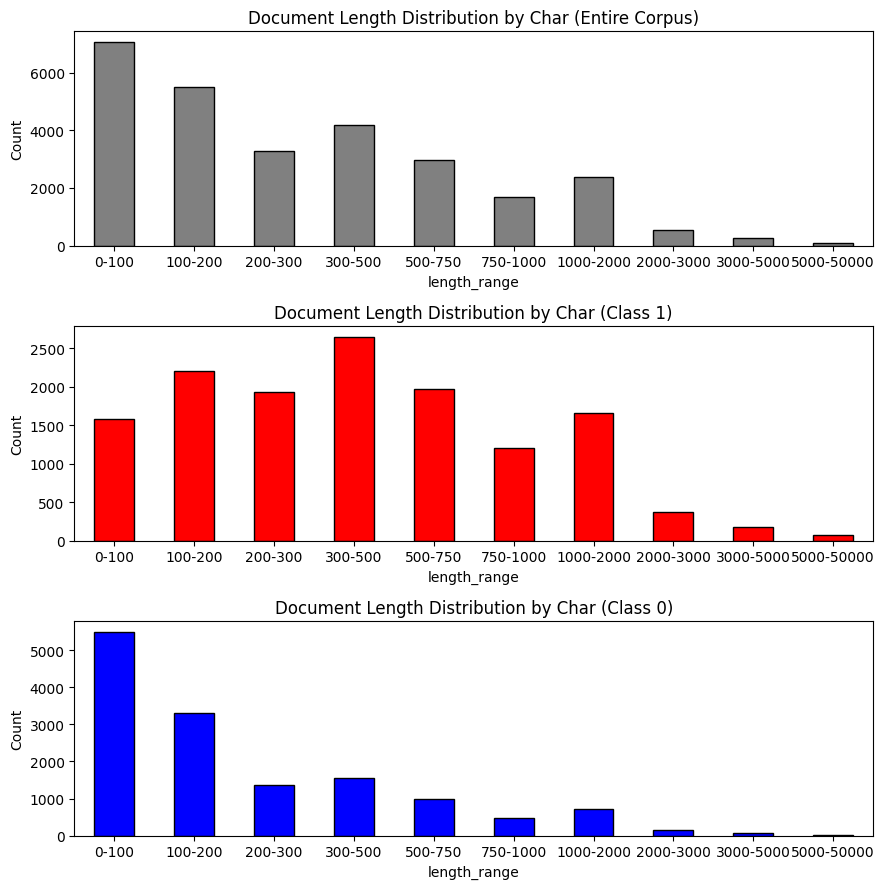

Entire Corpus (by char):
length_range
0-100         7084
100-200       5511
200-300       3287
300-500       4200
500-750       2957
750-1000      1697
1000-2000     2373
2000-3000      533
3000-5000      254
5000-50000      81
Name: count, dtype: int64

Class 1 (by char):
length_range
0-100         1577
100-200       2212
200-300       1931
300-500       2654
500-750       1976
750-1000      1209
1000-2000     1654
2000-3000      370
3000-5000      183
5000-50000      72
Name: count, dtype: int64

Class 0 (by char):
length_range
0-100         5507
100-200       3299
200-300       1356
300-500       1546
500-750        981
750-1000       488
1000-2000      719
2000-3000      163
3000-5000       71
5000-50000       9
Name: count, dtype: int64


In [5]:
# Quan sát phân bổ của độ dài theo char của các điểm dữ liệu
bins = [0, 100, 200, 300, 500, 750, 1000, 2000, 3000, 5000, 50000]
labels = ['0-100', '100-200', '200-300', '300-500', '500-750', '750-1000', '1000-2000', '2000-3000', '3000-5000', '5000-50000']

corpus['document_length'] = corpus['text'].apply(len)

corpus['length_range'] = pd.cut(corpus['document_length'], bins=bins, labels=labels, right=False)
class_1 = corpus[corpus['label'] == 1]
class_0 = corpus[corpus['label'] == 0]

total_counts = corpus['length_range'].value_counts().sort_index()
class_1_counts = class_1['length_range'].value_counts().sort_index()
class_0_counts = class_0['length_range'].value_counts().sort_index()

plt.figure(figsize=(9, 9))

plt.subplot(3, 1, 1)
total_counts.plot(kind='bar', color='gray', edgecolor='black')
plt.title('Document Length Distribution by Char (Entire Corpus)')
plt.ylabel('Count')
plt.xticks(rotation=0)

plt.subplot(3, 1, 2)
class_1_counts.plot(kind='bar', color='red', edgecolor='black')
plt.title('Document Length Distribution by Char (Class 1)')
plt.ylabel('Count')
plt.xticks(rotation=0)

plt.subplot(3, 1, 3)
class_0_counts.plot(kind='bar', color='blue', edgecolor='black')
plt.title('Document Length Distribution by Char (Class 0)')
plt.ylabel('Count')
plt.xticks(rotation=0)

# plt.savefig('plots_and_graphs/org_char_length_distribution.png', format='png', dpi=300)

plt.tight_layout()
plt.show()

print("Entire Corpus (by char):")
print(total_counts)
print("\nClass 1 (by char):")
print(class_1_counts)
print("\nClass 0 (by char):")
print(class_0_counts)

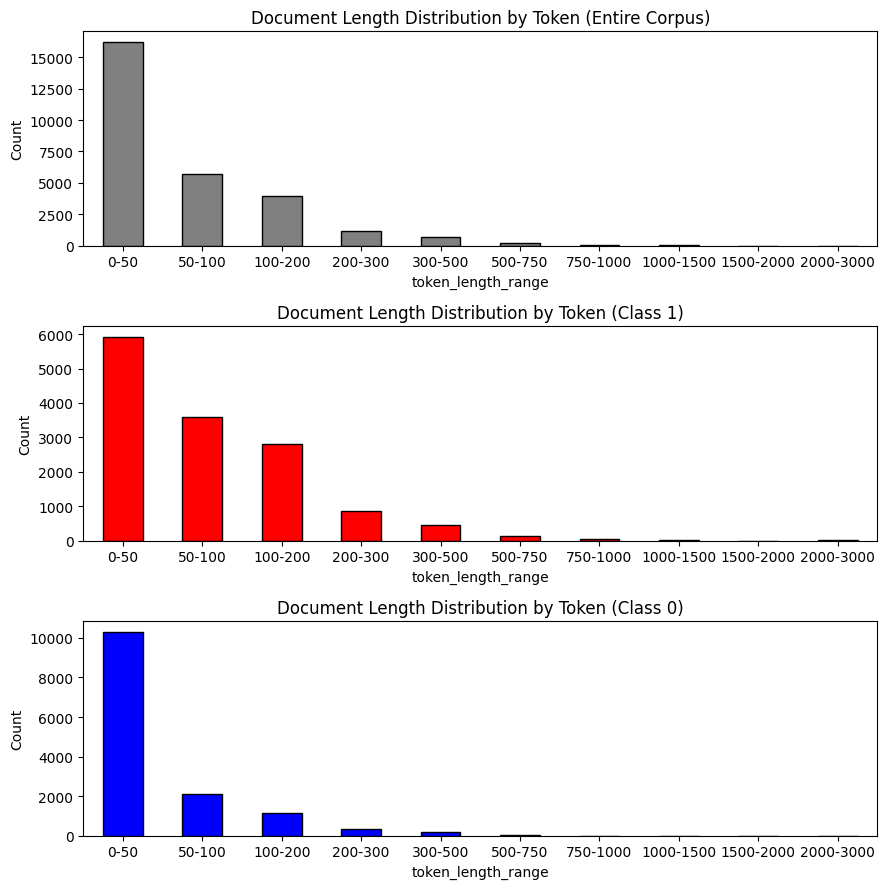

Entire Corpus (Token-based):
token_length_range
0-50         16258
50-100        5688
100-200       3935
200-300       1188
300-500        648
500-750        178
750-1000        50
1000-1500       27
1500-2000        1
2000-3000        4
Name: count, dtype: int64

Class 1 (Token-based):
token_length_range
0-50         5932
50-100       3589
100-200      2794
200-300       848
300-500       462
500-750       136
750-1000       47
1000-1500      25
1500-2000       1
2000-3000       4
Name: count, dtype: int64

Class 0 (Token-based):
token_length_range
0-50         10326
50-100        2099
100-200       1141
200-300        340
300-500        186
500-750         42
750-1000         3
1000-1500        2
1500-2000        0
2000-3000        0
Name: count, dtype: int64


In [6]:
# Quan sát phân bổ của độ dài theo tokens của các điểm dữ liệu
token_bins = [0, 50, 100, 200, 300, 500, 750, 1000, 1500, 2000, 3000]
token_labels = ['0-50', '50-100', '100-200', '200-300', '300-500', '500-750', '750-1000', '1000-1500', '1500-2000', '2000-3000']

corpus['token_length'] = corpus['text'].apply(lambda x: len(x.split()))

corpus['token_length_range'] = pd.cut(corpus['token_length'], bins=token_bins, labels=token_labels, right=False)

class_1_token = corpus[corpus['label'] == 1]
class_0_token = corpus[corpus['label'] == 0]

total_token_counts = corpus['token_length_range'].value_counts().sort_index()
class_1_token_counts = class_1_token['token_length_range'].value_counts().sort_index()
class_0_token_counts = class_0_token['token_length_range'].value_counts().sort_index()

plt.figure(figsize=(9, 9))

plt.subplot(3, 1, 1)
total_token_counts.plot(kind='bar', color='gray', edgecolor='black')
plt.title('Document Length Distribution by Token (Entire Corpus)')
plt.ylabel('Count')
plt.xticks(rotation=0)

plt.subplot(3, 1, 2)
class_1_token_counts.plot(kind='bar', color='red', edgecolor='black')
plt.title('Document Length Distribution by Token (Class 1)')
plt.ylabel('Count')
plt.xticks(rotation=0)

plt.subplot(3, 1, 3)
class_0_token_counts.plot(kind='bar', color='blue', edgecolor='black')
plt.title('Document Length Distribution by Token (Class 0)')
plt.ylabel('Count')
plt.xticks(rotation=0)

# plt.savefig('plots_and_graphs/org_token_length_distribution.png', format='png', dpi=300)

plt.tight_layout()
plt.show()

print("Entire Corpus (Token-based):")
print(total_token_counts)
print("\nClass 1 (Token-based):")
print(class_1_token_counts)
print("\nClass 0 (Token-based):")
print(class_0_token_counts)

In [7]:
# Dựa vào phương pháp tìm điểm dị thường, ta dựa vào độ dài của các văn bản để xác định có
# bao nhiêu văn bản có thể có là dị thường dựa vào độ dài
Q1 = corpus['document_length'].quantile(0.25)
Q3 = corpus['document_length'].quantile(0.75)

IQR = Q3 - Q1

lbound = Q1 - 1.5 * IQR
ubound = Q3 + 1.5 * IQR

print(f"Lower bound : {lbound}")
print(f"Upper bound : {ubound}")

outliers = corpus[(corpus['document_length'] < ubound) | (corpus['document_length'] > lbound)]

print(f"Number of outliers: {len(outliers)}")

mean_length_corpus = corpus['document_length'].mean()
mean_length_class_1 = corpus[corpus['label'] == 1]['document_length'].mean()
mean_length_class_0 = corpus[corpus['label'] == 0]['document_length'].mean()

print(f"Mean document length (Entire Corpus): {mean_length_corpus:.2f}")
print(f"Mean document length (Class 1): {mean_length_class_1:.2f}")
print(f"Mean document length (Class 0): {mean_length_class_0:.2f}")

Lower bound : -591.0
Upper bound : 1249.0
Number of outliers: 27977
Mean document length (Entire Corpus): 464.58
Mean document length (Class 1): 617.25
Mean document length (Class 0): 315.15


In [8]:
# Sử dụng Tokenizer để quan sát số Unique Tokens, Total Tokens
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus['text'])

sequences = tokenizer.texts_to_sequences(corpus['text'])

total_tokens = sum(len(seq) for seq in sequences)
unique_tokens = len(tokenizer.word_index)

class_1_text = corpus[corpus['label'] == 1]['text']
class_0_text = corpus[corpus['label'] == 0]['text']

class_1_sequences = tokenizer.texts_to_sequences(class_1_text)
class_0_sequences = tokenizer.texts_to_sequences(class_0_text)

total_tokens_class_1 = sum(len(seq) for seq in class_1_sequences)
total_tokens_class_0 = sum(len(seq) for seq in class_0_sequences)

tokenizer_class_1 = Tokenizer()
tokenizer_class_1.fit_on_texts(class_1_text)
unique_tokens_class_1 = len(tokenizer_class_1.word_index)

tokenizer_class_0 = Tokenizer()
tokenizer_class_0.fit_on_texts(class_0_text)
unique_tokens_class_0 = len(tokenizer_class_0.word_index)

print(f"Unique Tokens (Total): {unique_tokens}")
print(f"Total Tokens (Total): {total_tokens}")
print(f"Unique Tokens (Class 1): {unique_tokens_class_1}")
print(f"Total Tokens (Class 1): {total_tokens_class_1}")
print(f"Unique Tokens (Class 0): {unique_tokens_class_0}")
print(f"Total Tokens (Class 0): {total_tokens_class_0}")

Unique Tokens (Total): 72820
Total Tokens (Total): 2008931
Unique Tokens (Class 1): 42147
Total Tokens (Class 1): 1338203
Unique Tokens (Class 0): 49183
Total Tokens (Class 0): 670728


# Tóm tắt quá trình phân tích 1

### Chúng ta đã quan sát:
- Chúng ta thấy rằng có một số ít điểm dữ liệu có chứa kí tự ngoài các chữ cái Tiếng Anh viết thường và 2 điểm dữ liệu trống.
- Phân bổ cột `label`: Cho thấy đây là một bộ dữ liệu cân bằng, tỉ lệ của 2 class 1 và 0 xấp xỉ 50%.
- Phân tích độ dài của các văn bản theo char và theo tokens, phân tích tứ phân vị theo độ dài văn bản: Cho thấy rằng phân lớn các văn bản có độ dài trung bình ngắn hơn độ dài tối đa rất nhiều, điều này gợi ý về việc loại bỏ các điểm dị thường dựa vào độ dài văn bản.
- Phân tích số unique token trên tổng số token: Cho thấy lượng token unique của cả 2 lớp không chênh lệch quá nhiều, tuy nhiên tổng token của cả corpus rất lớn, điều này gợi ý rằng có rất nhiều token (từ ngữ) lặp lại trong corpus. Ngoài ra tổng số token của class 1 xấp xỉ gấp đôi tổng số token của class 0.

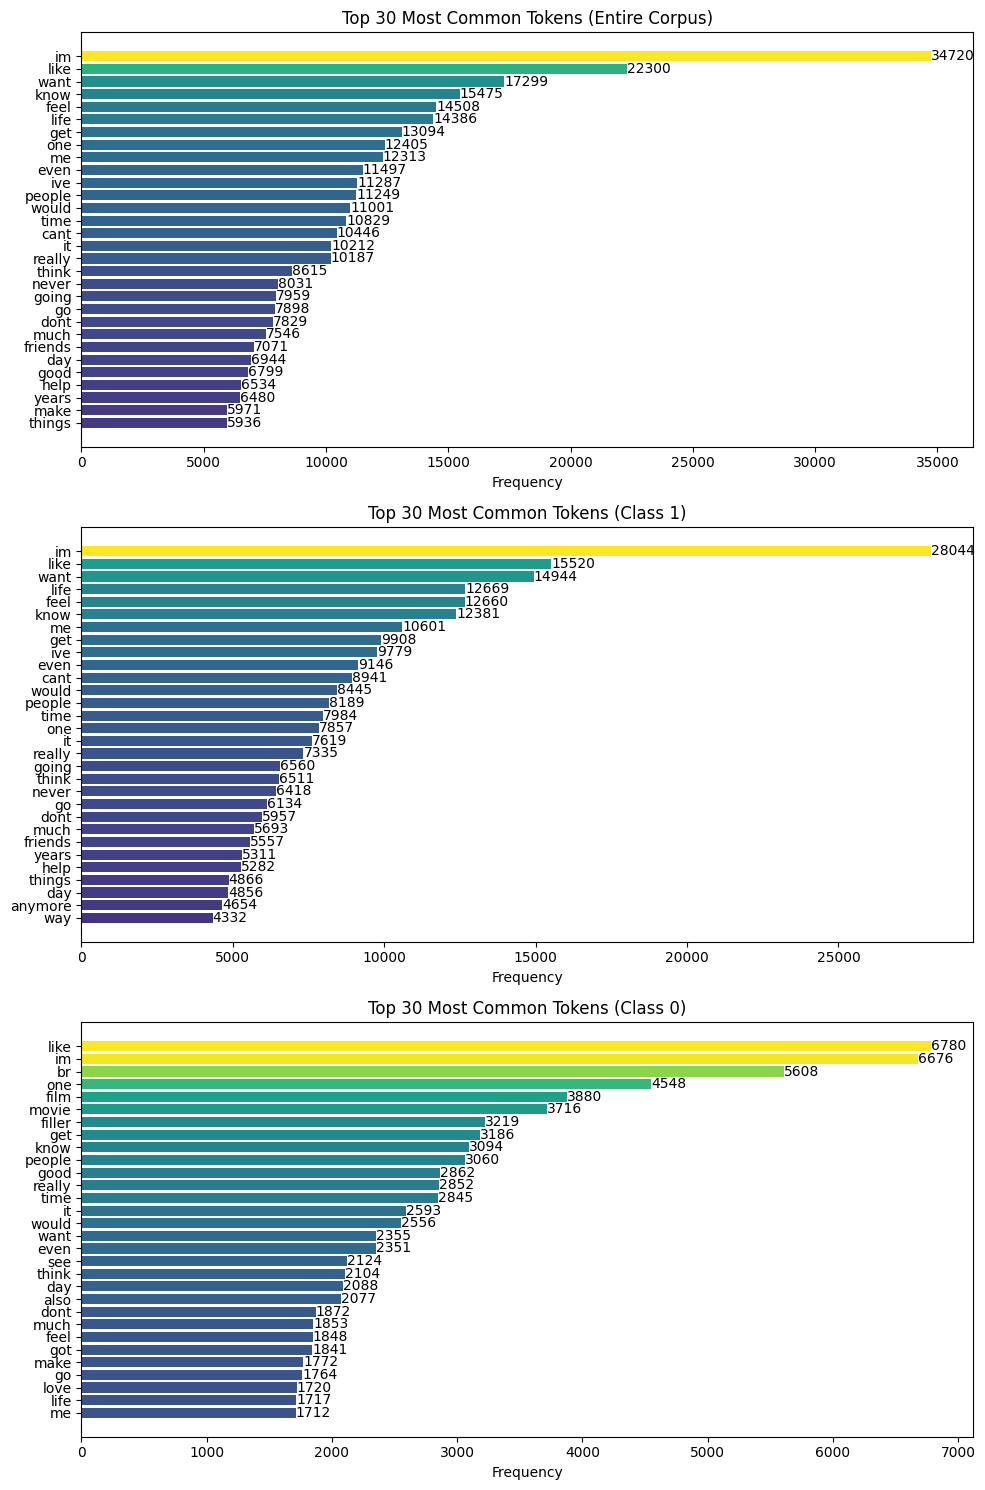

In [9]:
# Top 30 tokens có tần xuất cao nhất
def get_top_n_tokens(corpus, n=30):
    all_tokens = ' '.join(corpus['text']).split()
    token_counts = Counter(all_tokens)
    return token_counts.most_common(n)

top_tokens_corpus = get_top_n_tokens(corpus)
top_tokens_class_1 = get_top_n_tokens(corpus[corpus['label'] == 1])
top_tokens_class_0 = get_top_n_tokens(corpus[corpus['label'] == 0])

def prepare_plot_data(top_tokens):
    words, counts = zip(*top_tokens)
    return list(words), list(counts)

words_corpus, counts_corpus = prepare_plot_data(top_tokens_corpus)
words_class_1, counts_class_1 = prepare_plot_data(top_tokens_class_1)
words_class_0, counts_class_0 = prepare_plot_data(top_tokens_class_0)

def plot_top_tokens(words, counts, title, ax):
    bars = ax.barh(words, counts, color=cm.viridis(counts/np.max(counts)))
    ax.set_title(title)
    ax.set_xlabel('Frequency')
    ax.invert_yaxis()
    for bar in bars:
        ax.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{int(bar.get_width())}', va='center')

fig, axs = plt.subplots(3, 1, figsize=(10, 15))

plot_top_tokens(words_corpus, counts_corpus, 'Top 30 Most Common Tokens (Entire Corpus)', axs[0])

plot_top_tokens(words_class_1, counts_class_1, 'Top 30 Most Common Tokens (Class 1)', axs[1])

plot_top_tokens(words_class_0, counts_class_0, 'Top 30 Most Common Tokens (Class 0)', axs[2])

# plt.savefig('plots_and_graphs/org_top_30_most_common.png', format='png', dpi=300)

plt.tight_layout()
plt.show()

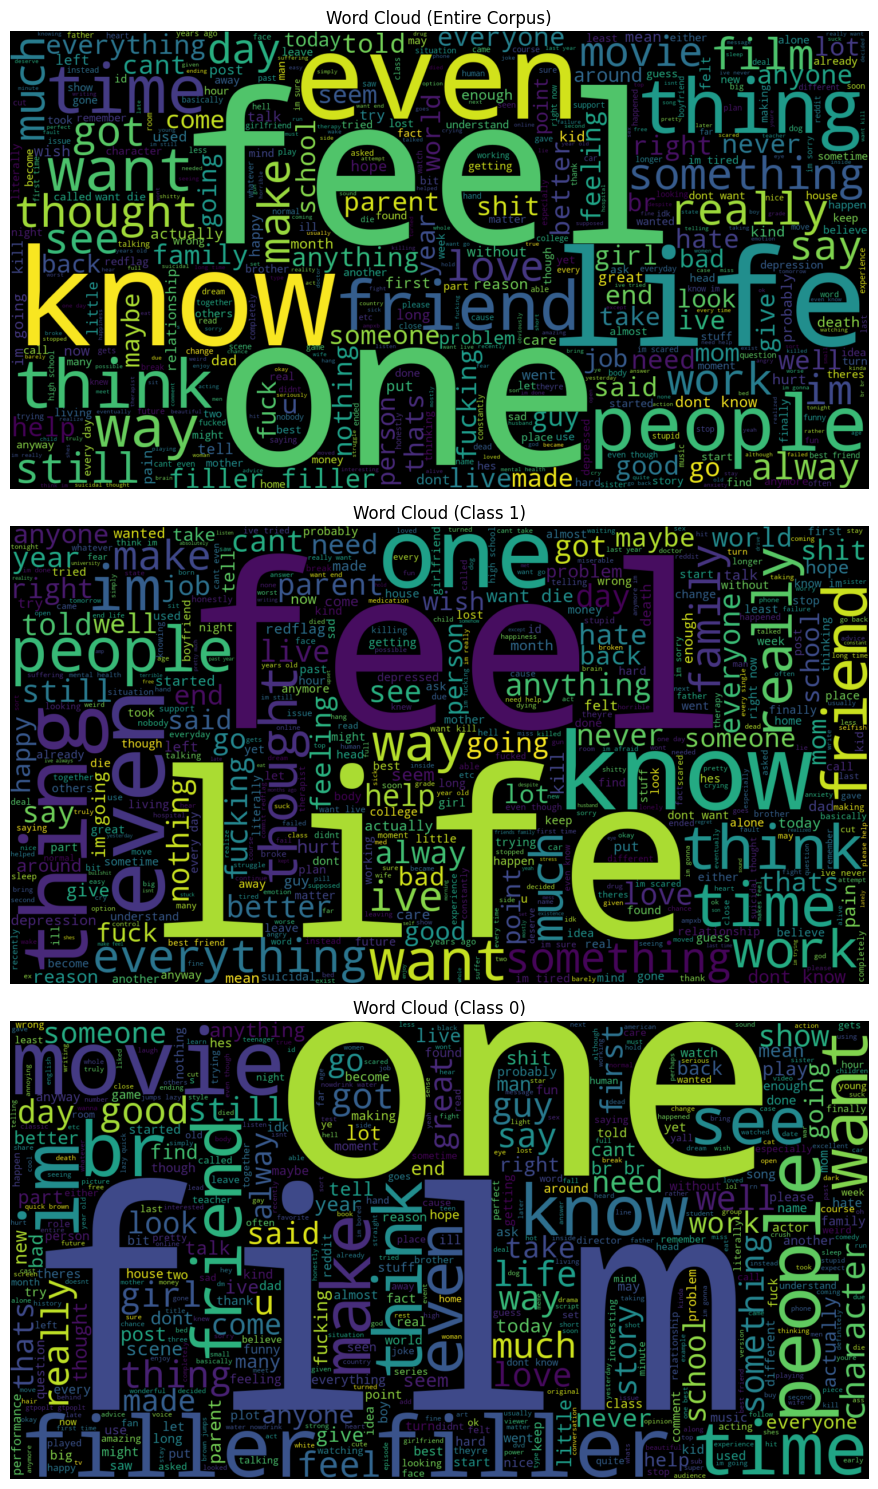

In [10]:
# Trực quan hóa bằng phương pháp Word Cloud
def create_word_cloud(text, title, ax):
    wordcloud = WordCloud(max_words=500, height= 800, width = 1500, background_color='black', colormap='viridis').generate(text)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis('off')
    ax.set_title(title)

text_corpus = ' '.join(corpus['text'])
text_class_1 = ' '.join(corpus[corpus['label'] == 1]['text'])
text_class_0 = ' '.join(corpus[corpus['label'] == 0]['text'])

fig, axs = plt.subplots(3, 1, figsize=(10, 15))

create_word_cloud(text_corpus, 'Word Cloud (Entire Corpus)', axs[0])

create_word_cloud(text_class_1, 'Word Cloud (Class 1)', axs[1])

create_word_cloud(text_class_0, 'Word Cloud (Class 0)', axs[2])

# plt.savefig('plots_and_graphs/org_word_clouds.png', format='png', dpi=300)

plt.tight_layout()
plt.show()

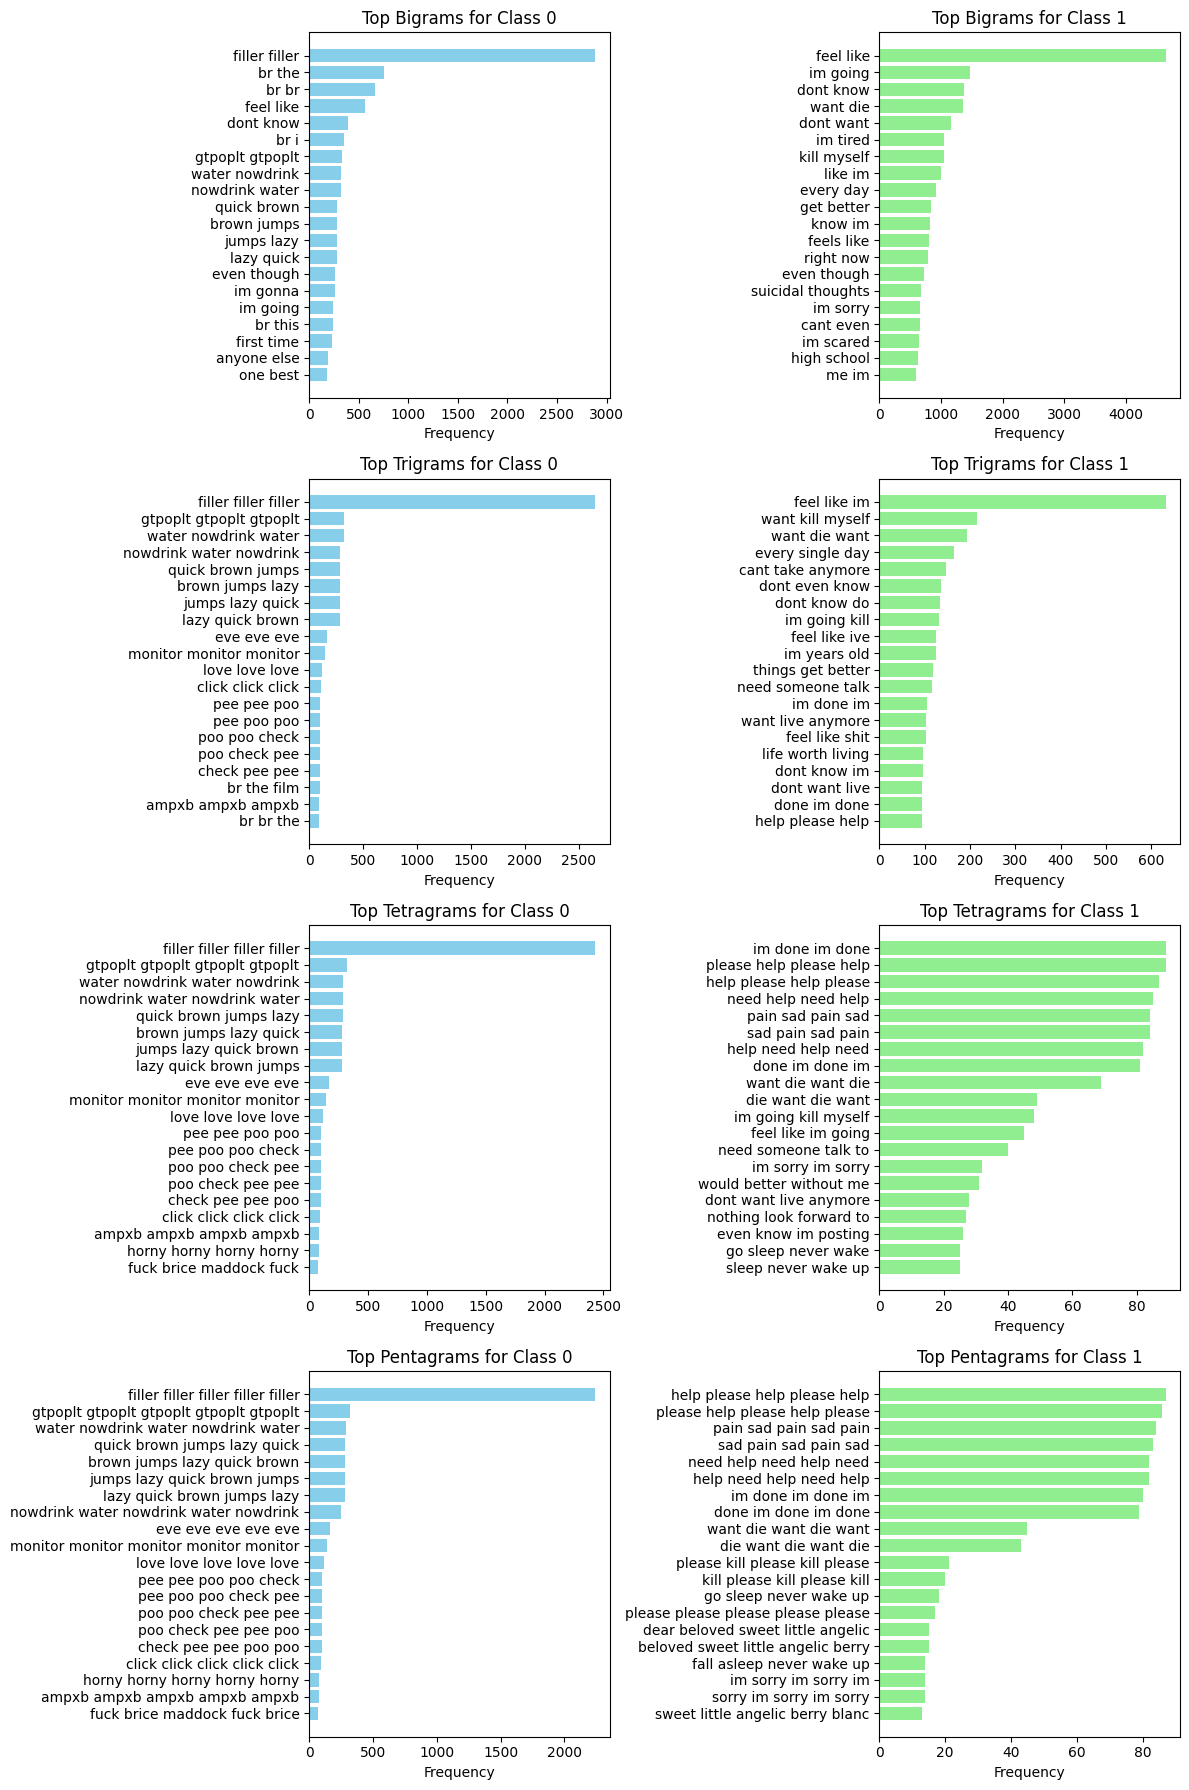

In [11]:
# Thực hiện phân tích n-grams với n = 2, 3, 4, 5
k = 20

def get_top_ngrams_with_tokenizer(corpus, n=2, top_k=10):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(corpus)
    sequences = tokenizer.texts_to_sequences(corpus)

    ngrams = []
    for seq in sequences:
        for i in range(len(seq) - n + 1):
            ngrams.append(tuple(seq[i:i + n]))

    ngram_freq = Counter(ngrams)
    return ngram_freq.most_common(top_k), tokenizer

ngram_results = {}

for n in range(2, 6):
    ngram_results[n] = {
        'class_0': get_top_ngrams_with_tokenizer(corpus[corpus['label'] == 0]['text'], n=n, top_k=k),
        'class_1': get_top_ngrams_with_tokenizer(corpus[corpus['label'] == 1]['text'], n=n, top_k=k)
    }

ngram_dfs = {}
for n in ngram_results:
    class_0_ngrams, tokenizer_0 = ngram_results[n]['class_0']
    class_1_ngrams, tokenizer_1 = ngram_results[n]['class_1']
    
    class_0_df = pd.DataFrame(class_0_ngrams, columns=['ngram', 'frequency'])
    class_0_df['ngram'] = class_0_df['ngram'].apply(lambda x: ' '.join([word for idx in x for word, word_idx in tokenizer_0.word_index.items() if idx == word_idx]))
    class_0_df['class'] = 0
    
    class_1_df = pd.DataFrame(class_1_ngrams, columns=['ngram', 'frequency'])
    class_1_df['ngram'] = class_1_df['ngram'].apply(lambda x: ' '.join([word for idx in x for word, word_idx in tokenizer_1.word_index.items() if idx == word_idx]))
    class_1_df['class'] = 1
    
    combined_df = pd.concat([class_0_df, class_1_df], ignore_index=True)
    ngram_dfs[n] = combined_df

fig, axs = plt.subplots(4, 2, figsize=(12, 18))

titles = [
    'Top Bigrams for Class 0',
    'Top Bigrams for Class 1',
    'Top Trigrams for Class 0',
    'Top Trigrams for Class 1',
    'Top Tetragrams for Class 0',
    'Top Tetragrams for Class 1',
    'Top Pentagrams for Class 0',
    'Top Pentagrams for Class 1'
]

for i, n in enumerate(range(2, 6)):
    class_0_data = ngram_dfs[n][ngram_dfs[n]['class'] == 0]
    axs[i, 0].barh(class_0_data['ngram'], class_0_data['frequency'], color='skyblue')
    axs[i, 0].set_title(titles[i * 2])
    axs[i, 0].set_xlabel('Frequency')
    axs[i, 0].invert_yaxis()

    class_1_data = ngram_dfs[n][ngram_dfs[n]['class'] == 1]
    axs[i, 1].barh(class_1_data['ngram'], class_1_data['frequency'], color='lightgreen')
    axs[i, 1].set_title(titles[i * 2 + 1])
    axs[i, 1].set_xlabel('Frequency')
    axs[i, 1].invert_yaxis()

# plt.savefig('plots_and_graphs/org_n_grams_analysis.png', format='png', dpi=300)

plt.tight_layout()
plt.show()

# Tóm tắt quá trình phân tích 2

### Chúng ta đã quan sát:

#### Phân tích các từ phổ biến nhất
- Phân tích Top 30 từ phổ biến nhất trong cả corpus:
    - Cỏ vẻ hầu hết là các từ ngữ thông dụng, điều này có thể gợi ý rằng có nhiều từ ngữ phổ biến trong cả 2 lớp 1 và 0.
- Phân tích Top 30 từ phổ biến nhất thuộc lớp 1:
    - Chúng ta nhận thấy rằng có vẻ như từ xưng hô ngôi thứ nhất 'im' chủ yếu thuộc về lớp 1, điều này được củng cố hơn bởi 1 nghiên cứu nói về mối quan hệ giữa việc sử dụng từ xưng hô ngôi thứ nhất và các loại rối loạn tâm lý.
    - Ngoài ra còn có 'feel' nói về cảm xúc, 'want' nói về ham muốn, etc...
- Phân tích Top 30 từ phổ biến nhất thuộc lớp 0:
    - Ta thấy phân bố của các từ có vẻ thấp hơn so với lớp 1, ngoài ra có 1 vài chủ đề phổ biến đặc thù như 'movie', 'film'
    - Một điều đáng chú ý là qua phân tích thì có vẻ như những từ như 'filler' hay 'br' (nghi ngờ là element \<br\> của HTML xót lại sau khi cạo dữ liệu) sẽ cần chúng ta xử lý một cách hợp lý sau.

#### Trực quan hóa bằng định dạng Word Cloud
- Chúng ta sử dụng Word Cloud - 1 dạng diagram mà ở đó những từ có tần suất lớn sẽ chiếm diện tích lớn hơn, điều này giúp chúng ta quan sát, trực quan hóa, và cung cấp thông tin cho cá nhân không trực tiếp thực hiện phân tích.

#### Phân tích n-Grams
- Đây là 1 kỹ thuật cơ bản trong NLP (Natural Language Processing), ta hiểu đơn giản n-Grams là bộ các n từ nối liền nhau (eg. one day -> bigrams, this day one -> trigrams, etc...)
- Đây là 1 trong những bước then chốt trong quá trình phân tích, bằng cách quan sát các n-Grams với n từ 2 đến 5 và phân chia ra 2 lớp khác nhau, ta nhận thấy:
    - Trong lớp 0: ta đã phát hiện rõ một số quy luật, phần lớn là các văn bản được "độn" thêm để mô phỏng cho những chủ đề không liên quan thuộc lớp 0, ta sẽ đưa ra quyết định về những trường hợp này ở phần dọn dữ liệu.
    - Trong lớp 1: tương tự, ta đã nhận thấy nhiều chủ đề cụ thể hơn khi phân tích n-Grams với lớp 1, phổ biến nhất là nhắc đến về chủ đề cảm xúc cá nhân, chủ đề tự hại, những lời kêu cứu và những từ ngữ mang hướng tiêu cực nói chung và qua cảm quan có thể nhận thấy rằng là các văn bản có nguy cơ biểu thị cho rối loạn tâm lí.

In [4]:
from collections import Counter
import pandas as pd
import re

k = 200

def get_least_common_n_tokens(corpus, min_freq, max_freq, n=20):
    all_tokens = ' '.join(corpus['text']).split()
    token_counts = Counter(all_tokens)
    least_common = [(word, freq) for word, freq in token_counts.items() if min_freq <= freq < max_freq]
    return sorted(least_common, key=lambda x: x[1])[:n]

ranges = [(10, 12)]

for min_freq, max_freq in ranges:
    least_common_tokens = get_least_common_n_tokens(corpus, min_freq, max_freq, k)

    least_common_words = pd.DataFrame(least_common_tokens, columns=['word', 'frequency'])
    
    least_common_words['class'] = least_common_words['word'].apply(
        lambda x: corpus.loc[corpus['text'].str.contains(r'\b' + re.escape(x) + r'\b', na=False), 'label'].mode().get(0, None)
    )
    
    print(f"\nTop {k} Least Common Words with Frequency from {min_freq} to {max_freq}:")
    for _, row in least_common_words.iterrows():
        print(f"Word: '{row['word']}', Frequency: {row['frequency']}, Class: {row['class']}")

    class_counts = least_common_words['class'].value_counts()
    print(f"\nClass counts for frequency range {min_freq} to {max_freq}:")
    print(f"Class 0 Instances: {class_counts.get(0, 0)}")
    print(f"Class 1 Instances: {class_counts.get(1, 0)}")


Top 200 Least Common Words with Frequency from 4 to 6:
Word: 'graders', Frequency: 4, Class: 0
Word: 'betterthe', Frequency: 4, Class: 1
Word: 'victimized', Frequency: 4, Class: 0
Word: 'mount', Frequency: 4, Class: 0
Word: 'mailing', Frequency: 4, Class: 1
Word: 'figurative', Frequency: 4, Class: 1
Word: 'gaslights', Frequency: 4, Class: 1
Word: 'illuminati', Frequency: 4, Class: 0
Word: 'fraught', Frequency: 4, Class: 0
Word: 'reserves', Frequency: 4, Class: 1
Word: 'minions', Frequency: 4, Class: 0
Word: 'gremlins', Frequency: 4, Class: 0
Word: 'detox', Frequency: 4, Class: 1
Word: 'nonjudgmental', Frequency: 4, Class: 1
Word: 'grape', Frequency: 4, Class: 0
Word: 'pariah', Frequency: 4, Class: 1
Word: 'narcolepsy', Frequency: 4, Class: 1
Word: 'hereditary', Frequency: 4, Class: 1
Word: 'farrell', Frequency: 4, Class: 0
Word: 'cyberbullied', Frequency: 4, Class: 0
Word: 'guesses', Frequency: 4, Class: 0
Word: 'retaking', Frequency: 4, Class: 1
Word: 'bryce', Frequency: 4, Class: 0


In [13]:
# Tính toán 50 từ dài nhất
def get_longest_n_words(corpus, n=50):
    all_tokens = ' '.join(corpus['text']).split()
    unique_words = set(all_tokens)
    longest_words = sorted(unique_words, key=len, reverse=True)
    return longest_words[:n]

longest_words = get_longest_n_words(corpus)

print("Top 50 Longest Words:")
for word in longest_words:
    rows_with_word = corpus[corpus['text'].str.contains(r'\b' + re.escape(word) + r'\b', na=False)].index.tolist()
    truncated_word = word if len(word) <= 15 else word[:70] + '...'
    print(f"Word: {truncated_word}, Found in rows: {rows_with_word}")

Top 50 Longest Words:
Word: aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa..., Found in rows: [5343]
Word: gtoltgtoltgtoltgtoltgtoltgtoltgtoltgtoltgtoltgtoltgtoltgtoltgtoltgtolt..., Found in rows: [25866]
Word: whiskeyhotelyankeemikeechowhiskeyhotelyankeemikeechowhiskeyhotelyankee..., Found in rows: [4094]
Word: fillerfillerfillerfillerfillerfillerfillerfillerfillerfillerfillerfill..., Found in rows: [13957]
Word: aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa..., Found in rows: [13843]
Word: ahhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhh..., Found in rows: [21177]
Word: httpsconsumertrendsnewscomsurprisingnewtechpvcepczercfiyxylppysedjsuip..., Found in rows: [7837]
Word: nhttpsbeepboxcoplayersongnsbklejtmagnjfirotvluaqdfayzccacfbevqpffffetv..., Found in rows: [18472]
Word: wwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwweeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee..., Found in rows: [6916]
Word: egslknfioooooohbgjtnfhodiknlgttttttttttt

In [14]:
# Tính toán độ dài ký tự tối đa và trung bình của các từ
all_tokens = ' '.join(corpus['text']).split()
char_lengths = [len(word) for word in all_tokens]

max_length = max(char_lengths)
mean_length = sum(char_lengths) / len(char_lengths)

print(f"Maximum character length of a word: {max_length}")
print(f"Mean character length of words: {mean_length:.2f}")

Maximum character length of a word: 25272
Mean character length of words: 5.47


In [15]:
# Đếm số lượng liên kết và in ra một số ví dụ
links = corpus[corpus['text'].str.contains(r'(http|www)', na=False)]

# Print the number of links and a few examples with original row indices
num_links = len(links)
print(f"Total number of links found: {num_links}")

print("Examples of links:")
for index in links.index[:5]:
    print(f"Link in row {index}: {links.loc[index]['text']}")

Total number of links found: 739
Examples of links:
Link in row 16: guy coming sure wear f hey guy friend coming tomorrow im excited im sure wear ive known since middle school weve talking couple months and honest know really care wear will want wear dress something thatd give way feminine impression like dresses often want give impression me makes sense im thinking wearing cargo shorts friends tell nobody likes cargo shorts though like normal pants know of cargo pants thing is seen person since  want make absolutely sure good impression want look nice like put much effort casual like care im gonna light makeup ive got couple pics makeup im gonna bc makeup like yesterday anyone wants see makeup uh guess ill link it also anyone makeup advice hmu think ill worry nails ill probably something pastelmakeup lookhttpsimgurcomaqaorpl
Link in row 24: im warn you please hear out hello getting straight point searching friends know basic daily stuff hitted upon someone nickname  umykittylolitahttp

In [16]:
# Thử nghiệm về lỗi chính tả trong corpus
spell = SpellChecker()

def find_spelling_errors_with_corrections(corpus, num_samples=5):
    suspected_errors = []
    corrections = {}
    for text in corpus['text'][:num_samples]:
        words = text.translate(str.maketrans('', '', string.punctuation)).lower().split()
        unknown_words = spell.unknown(words)
        for word in unknown_words:
            suspected_errors.append(word)
            candidates = spell.candidates(word)
            corrections[word] = candidates if candidates else []
    return suspected_errors, corrections

spelling_errors, proposed_corrections = find_spelling_errors_with_corrections(corpus, num_samples=5)

total_errors = len(spelling_errors)
print(f"Total number of suspected spelling errors in the first 5 samples: {total_errors}")

print("Examples of suspected spelling errors and proposed corrections:")
for error in spelling_errors:
    print(f"Error: {error}, Proposed Corrections: {list(proposed_corrections[error])}")

Total number of suspected spelling errors in the first 5 samples: 35
Examples of suspected spelling errors and proposed corrections:
Error: american, Proposed Corrections: ['america']
Error: sooooo, Proposed Corrections: ['boohoo', 'hoodoo', 'koodoo', 'booboo', 'voodoo']
Error: thth, Proposed Corrections: ['teth']
Error: dont, Proposed Corrections: ['font', 'don', 'dint', 'dunt', 'dona', 'done', 'dent', 'dons', 'dot', 'dong', 'doit', "don't", 'dolt', 'donut', 'wont', 'dost']
Error: lifei, Proposed Corrections: ['life', 'lifer']
Error: minnesota, Proposed Corrections: []
Error: genresartists, Proposed Corrections: []
Error: alt, Proposed Corrections: ['ale', 'alit', 'apt', 'all', 'alb', 'salt', 'ant', 'alto', 'art', 'act', 'malt', 'halt', 'at', 'ait', 'aft', 'ala', 'alp']
Error: scott, Proposed Corrections: ['scout', 'scoot']
Error: artistssongs, Proposed Corrections: []
Error: penelope, Proposed Corrections: ['envelope']
Error: aliceband, Proposed Corrections: []
Error: rhymesayers, Pr

In [17]:
def clean_repeated_characters(corpus):
    modified_corpus = corpus.copy()
    changes_printed = 0  # Counter for printed changes
    max_changes_to_print = 200  # Maximum changes to print

    for index, row in modified_corpus.iterrows():
        original_text = row['text']
        # Replace characters that are repeated 3 or more times with a single instance
        modified_text = re.sub(r'(.)\1{2,}', r'\1', original_text)
        modified_corpus.at[index, 'text'] = modified_text

        # Print out examples of changes, only if the original text is less than 400 characters
        if original_text != modified_text and len(original_text) < 400:
            print(f"Row {index}: '{original_text}' -> '{modified_text}'")
            changes_printed += 1
            
            if changes_printed >= max_changes_to_print:  # Stop after printing the max number
                break
    
    return modified_corpus

# Apply the cleaning function
cleaned_corpus = clean_repeated_characters(corpus)

Row 0: 'dear american teens question dutch person heard guys get way easier things learn age us sooooo thth graders like  right guys learn math' -> 'dear american teens question dutch person heard guys get way easier things learn age us so thth graders like  right guys learn math'
Row 31: 'got friends prank call yoooooo yall got numbers boys prank call us' -> 'got friends prank call yo yall got numbers boys prank call us'
Row 48: 'keep ya head bro girls call ugly want remember go   swipe makeup remover keep ya head king' -> 'keep ya head bro girls call ugly want remember go swipe makeup remover keep ya head king'
Row 59: 'hello anyone feeling suicidal hear people lying truth httpswwwyoutubecomwatchvjkcjcbtqehttpswwwyoutubecomwatchvjkcjcbtqe feel suicidal go' -> 'hello anyone feeling suicidal hear people lying truth httpswyoutubecomwatchvjkcjcbtqehttpswyoutubecomwatchvjkcjcbtqe feel suicidal go'
Row 63: 'got  practicals files  chem project   assignments software based project submit tom

# Tóm tắt quá trình phân tích 3

### Chúng ta đã quan sát:
- Những từ ngữ có tần suất thấp có vẻ phân lớn là các lỗi chính tả và được phân bổ đều giữa cả 2 lớp.
- Có những trường hợp của những token có độ dài bất thường, ta sẽ cần xử lý những trường hợp này, ngoài ra nhận thấy rằng ký tự '_' vẫn phổ biến trong bộ dữ liệu.
- Những đường link cũng phần nào phổ biến trong bộ dữ liệu.
- Thí nghiệm về việc sửa lỗi chính tả trong bộ dữ liệu, với những ví dụ được in ra, ta quyết định sẽ không thực hiện chữa lỗi chính tả trực tiếp.
- Thử nghiệm về việc xử lí những trường hợp 1 char lặp lại nhiều lần, với kết quả khi thu gọn chúng xuống còn 1 char (eg. ddddddd -> d) ta sẽ thực hiện bước này ở phần dọn dữ liệu.
- Ngoài ra, ta quyết định sẽ loại bỏ những từ chỉ có 1 kí tự dựa trên những phân tích tại đây

In [21]:
from collections import Counter

# Find all tokens that end with any letter from 'a' to 'z'
tokens_ending_with_char = [token for text in corpus['text'] for token in text.split() if token[-1].isalpha()]

# Count the frequency of tokens ending with each letter
ending_char_counts = Counter(token[-1] for token in tokens_ending_with_char)

# Print the total count for each letter from 'a' to 'z'
for letter in 'abcdefghijklmnopqrstuvwxyz':
    print(f"Total number of tokens ending with '{letter}': {ending_char_counts[letter]}")

Total number of tokens ending with 'a': 16347
Total number of tokens ending with 'b': 7346
Total number of tokens ending with 'c': 10760
Total number of tokens ending with 'd': 217364
Total number of tokens ending with 'e': 370541
Total number of tokens ending with 'f': 13231
Total number of tokens ending with 'g': 154930
Total number of tokens ending with 'h': 44742
Total number of tokens ending with 'i': 10292
Total number of tokens ending with 'j': 204
Total number of tokens ending with 'k': 54783
Total number of tokens ending with 'l': 93455
Total number of tokens ending with 'm': 63047
Total number of tokens ending with 'n': 96867
Total number of tokens ending with 'o': 33144
Total number of tokens ending with 'p': 27514
Total number of tokens ending with 'q': 251
Total number of tokens ending with 'r': 107326
Total number of tokens ending with 's': 229538
Total number of tokens ending with 't': 241067
Total number of tokens ending with 'u': 3632
Total number of tokens ending with

In [27]:
# Find all tokens that end with the letter 'i'
tokens_ending_with_i = [token for text in corpus['text'] for token in text.split() if token.endswith('i')]

# Count the frequency of these tokens
token_freq_ending_with_i = Counter(tokens_ending_with_i)

# Sort tokens by frequency in descending order
sorted_tokens_ending_with_i = token_freq_ending_with_i.most_common()

# Print the total count and the sorted tokens with their frequencies
print(f"Total number of tokens ending with 'i': {len(tokens_ending_with_i)}")
print("Tokens that end with 'i' by frequency (highest to lowest):")
for token, freq in sorted_tokens_ending_with_i:
    print(f"{token}: {freq}")

Total number of tokens ending with 'i': 10292
Tokens that end with 'i' by frequency (highest to lowest):
i: 2049
hi: 246
mei: 220
iti: 183
anymorei: 154
myselfi: 149
uni: 140
bi: 96
diei: 95
helpi: 91
lifei: 90
anti: 88
nowi: 61
redflagi: 60
thisi: 60
ii: 59
doi: 59
scifi: 55
upi: 47
toi: 46
againi: 45
nazi: 37
mini: 36
mi: 35
donei: 33
herei: 33
suicidali: 32
hentai: 32
tiredi: 32
livei: 32
wifi: 31
alli: 31
semi: 30
dayi: 30
endi: 28
youi: 28
worsei: 28
todayi: 27
anythingi: 27
dori: 27
outi: 26
sooni: 26
lofi: 26
peoplei: 25
fi: 25
cgi: 25
alivei: 25
oni: 23
nighti: 23
livingi: 23
wwii: 23
alonei: 22
taxi: 22
worldi: 22
emoji: 22
gti: 22
sci: 21
themi: 21
boi: 21
thoughtsi: 21
muchi: 21
timei: 21
tonighti: 21
paini: 21
pleasei: 20
betteri: 19
goi: 19
nothingi: 19
spaghetti: 19
scaredi: 19
samurai: 19
iii: 19
ai: 18
lefti: 18
polanski: 18
wayi: 18
ssri: 17
fbi: 17
familyi: 17
everythingi: 17
pointi: 17
ami: 16
deathi: 16
thati: 16
happyi: 15
friendi: 15
morei: 15
tomorrowi: 14
everyo

# Tóm tắt quá trình phân tích 4

### Chúng ta đã quan sát:
- Qua việc theo dõi tần suất của cái token kết thúc theo từng chữ cái từ 'a' đến 'z', ta phát hiện ra rằng phần lớn các token kết thúc với ký tự 'i' thường là viết sai chính tả, phổ biển với các trường hợp 1 danh từ cộng với đại từ ngôi thứ nhất (eg. lonelyi -> lonely i, suicidali -> suicidal i), ta sẽ xử lý những trường hợp này ở phần dọn dữ liệu.